In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from data_processing import dataset
from models import model
from utils import tools
from plots import plots, edge_detection_plots

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

2023-02-06 19:57:45.197562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 19:57:45.285727: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-06 19:57:45.306558: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-06 19:57:45.705987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
config_directory = 'with_prior_test'

config_path = os.path.join(os.getcwd(), 'configs', config_directory)
DataProcessing = dataset.DataProcessing(config_path=config_path)
Model = model.Model(config_path)
tools.parser(Model.cfg, DataProcessing.cfg)
Model.load_data(DataProcessing.cfg["NAME"])
DataProcessing.load_dataset_information()

2023-02-06 19:57:47.972023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 19:57:47.978451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 19:57:47.978581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 19:57:47.979089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

# Load Dataset, Preprocess Images and Dataset

In [3]:
train_ds, img_count_train = DataProcessing.load_dataset(DataProcessing.key.train)
test_ds, img_count_test = DataProcessing.load_dataset(DataProcessing.key.test)

real_world_ds, img_count_real_world_ds = DataProcessing.load_dataset(DataProcessing.key.real_world)

if Model.train_model:
    for inp, out in train_ds.take(2):
        edge_detection_plots.plot_edges(images=inp['in_img'], labels_edge=out['out_edge'],
                                        prior = inp['in_edge'],
                                        batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'])

The TRAIN DS contains 50 images.
The TEST DS contains 50 images.
The REAL_WORLD DS contains 861 images.


# Define, Compile and Train Model

In [4]:
history=Model.train(train_ds, test_ds, 
            DataProcessing.input_data_cfg, 
            DataProcessing.output_data_cfg, 
            img_count_train, 
            DataProcessing.cfg['TRAIN']['BATCH_SIZE'])

model = Model.get_best_model_from_checkpoints()

/home/david/SemesterProject/Models/edge_detection/with_prior_test/CKPT/ckpt-loss=984.09-epoch=140.00-f1=0.9408


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/with_prior_test/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/with_prior_test/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/with_prior_test/TFLITE/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/with_prior_test/TFLITE/assets


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_img (InputLayer)            [(None, 320, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 90, 30)  840         ['in_img[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 90, 60)  1860        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 90, 60)  240        ['conv2d_1[0][0]']           

 conv2d_8 (Conv2D)              (None, 80, 45, 20)   820         ['re_lu_7[0][0]']                
                                                                                                  
 in_edge (InputLayer)           [(None, 80, 45, 1)]  0           []                               
                                                                                                  
 batch_normalization_11 (BatchN  (None, 80, 45, 20)  80          ['conv2d_8[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 80, 45, 5)    50          ['in_edge[0][0]']                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 80, 45, 20)  600         ['batch_normalization_11[0][0]'] 
 v2D)     

                                                                                                  
 re_lu_19 (ReLU)                (None, 80, 45, 10)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 80, 45, 10)   910         ['re_lu_19[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 160, 90, 10)  210         ['batch_normalization_5[0][0]']  
                                                                                                  
 batch_normalization_23 (BatchN  (None, 80, 45, 10)  40          ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

# Plot Results

2023-02-06 19:58:33.590078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-02-06 19:58:34.680802: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Max Accuracy Score = 0.966 at 0.950
MF1 = 0.549
MF1_1 = 0.549, ODS_1 = 0.900
1/1 [==============================] - 0s 348ms/step


2023-02-06 20:00:15.077950: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 1 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

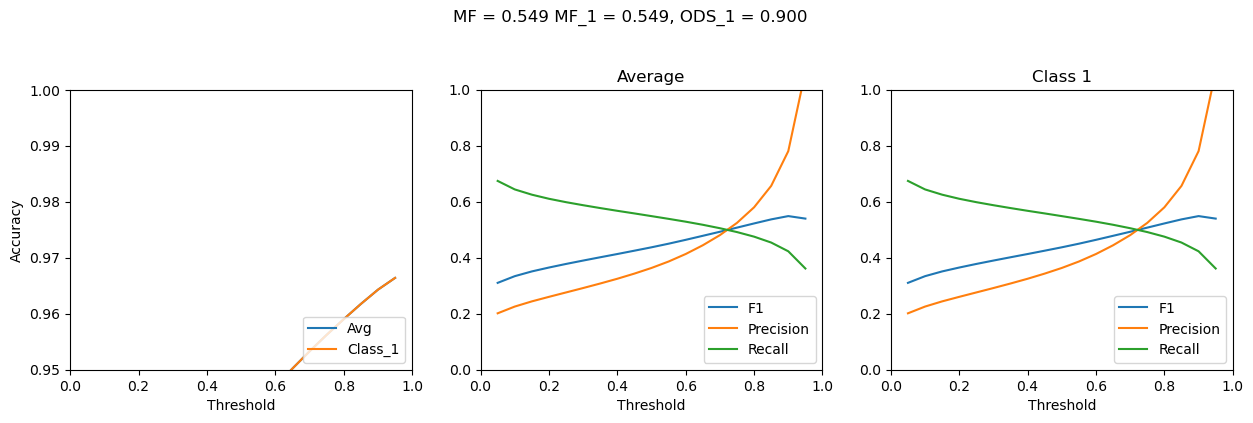

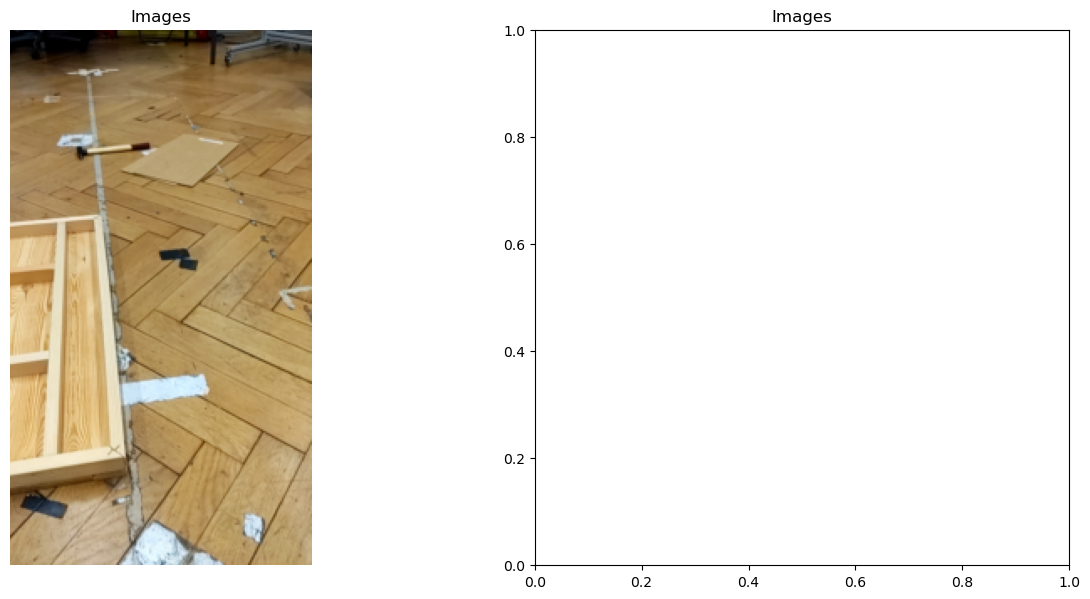

In [6]:
for i in range(2):
    ds_small = real_world_ds.skip(41*i).take(41)

    path = os.path.join(Model.Data.paths["FIGURES"],"threshold_metrics_evaluation_width_{}.svg".format(i))

    Model.evaluate_and_plot_MF_score(model=model, dataset=real_world_ds, 
                                    num_classes=DataProcessing.output_data_cfg["edge"]["num_classes"], 
                                    path=path, threshold_edge_width=1.0)
    
    j = 0
    for inp, out in ds_small.take(5):
        pred = model.predict(inp)
        path = os.path.join(Model.Data.paths["FIGURES"], "rwd_prediction_{}_{}".format(i,j))
        edge_detection_plots.plot_edges(images=inp['in_img'],
                                        prior = inp['in_edge'],
                                        labels_edge=out['out_edge'],
                                        predictions_edge=pred[0],
                                        batch_size=DataProcessing.cfg['REAL_WORLD']['BATCH_SIZE'],
                                       save=Model.cfg["SAVE"], path=path)
        j += 1
    
    